# Iyzico Transaction Prediction

## EDA

In [1]:
!pip install lightgbm
# conda install lightgbm

In [2]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# transaction_date: Date of sales data
# merchant_id: IDs of member businesses (Unique number for each member business)
# Total_Transaction: Number of transactions
# Total_Paid: Payment amount

In [4]:
df_ = pd.read_csv("/kaggle/input/transactions-dataset/iyzico_data.csv", parse_dates=['transaction_date'])
df = df_.copy()
df.head()

,Unnamed: 0,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,0,2018-01-01,535,349,25883.226
1,1,2018-01-01,42616,141,40918.860
2,2,2018-01-01,46774,410,306902.700
3,3,2018-01-01,86302,10,11.340
4,4,2018-01-01,124381,285,111383.766


In [5]:
df = df.drop(['Unnamed: 0'], axis=1)

In [6]:
df

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766
...,...,...,...,...
7662,2020-12-31,46774,3394,3174751.332
7663,2020-12-31,57192,856,337696.020
7664,2020-12-31,86302,2657,10461.006
7665,2020-12-31,124381,3668,2445655.950


In [7]:
df.dtypes

,0
transaction_date,datetime64[ns]
merchant_id,int64
Total_Transaction,int64
Total_Paid,float64


In [8]:
df.isnull().sum()

,0
transaction_date,0
merchant_id,0
Total_Transaction,0
Total_Paid,0


In [9]:
df['merchant_id'].value_counts()

,count
merchant_id,
535,1096
42616,1096
46774,1096
86302,1096
124381,1096
129316,1096
57192,1091


In [10]:
df['merchant_id'] = df['merchant_id'].astype('category')

In [11]:
#Dataset start and end dates
df['transaction_date'].min(), df['transaction_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_date,7667,2019-07-02 20:31:42.595539200,2018-01-01 00:00:00,2018-10-02 00:00:00,2019-07-03 00:00:00,2020-04-02 00:00:00,2020-12-31 00:00:00,NaN
Total_Transaction,7667.0,1094.463545,1.0,433.0,815.0,1316.5,34617.0,1294.123468
Total_Paid,7667.0,464176.413601,9.0,3278.475,186434.532,437640.723,12113121.618002,844857.916145


In [13]:
df.groupby('merchant_id').agg({'Total_Transaction':'sum',
                              'Total_Paid':'sum'})

,Total_Transaction,Total_Paid
merchant_id,,
535,1302725,1.566015e+08
42616,1126191,3.545831e+08
46774,1599559,1.567200e+09
57192,1146440,3.173371e+08
86302,840951,2.870447e+06
124381,1935357,1.158693e+09
129316,440029,1.555471e+06


## Feature Engineering

In [14]:
#Date Features
def create_date_features(df):
    df['month'] = df.transaction_date.dt.month
    df['day_of_month'] = df.transaction_date.dt.day
    df['day_of_year'] = df.transaction_date.dt.dayofyear
    df['week_of_year'] = df['transaction_date'].dt.isocalendar().week
    df['day_of_week'] = df.transaction_date.dt.dayofweek
    df['year'] = df.transaction_date.dt.year
    df["is_wknd"] = df.transaction_date.dt.weekday // 4
    df['is_month_start'] = df.transaction_date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.transaction_date.dt.is_month_end.astype(int)
    df['is_15th_day'] = (df['transaction_date'].dt.day == 15).astype(int)
    df['quarter'] = df.transaction_date.dt.quarter
    return df

df = create_date_features(df)

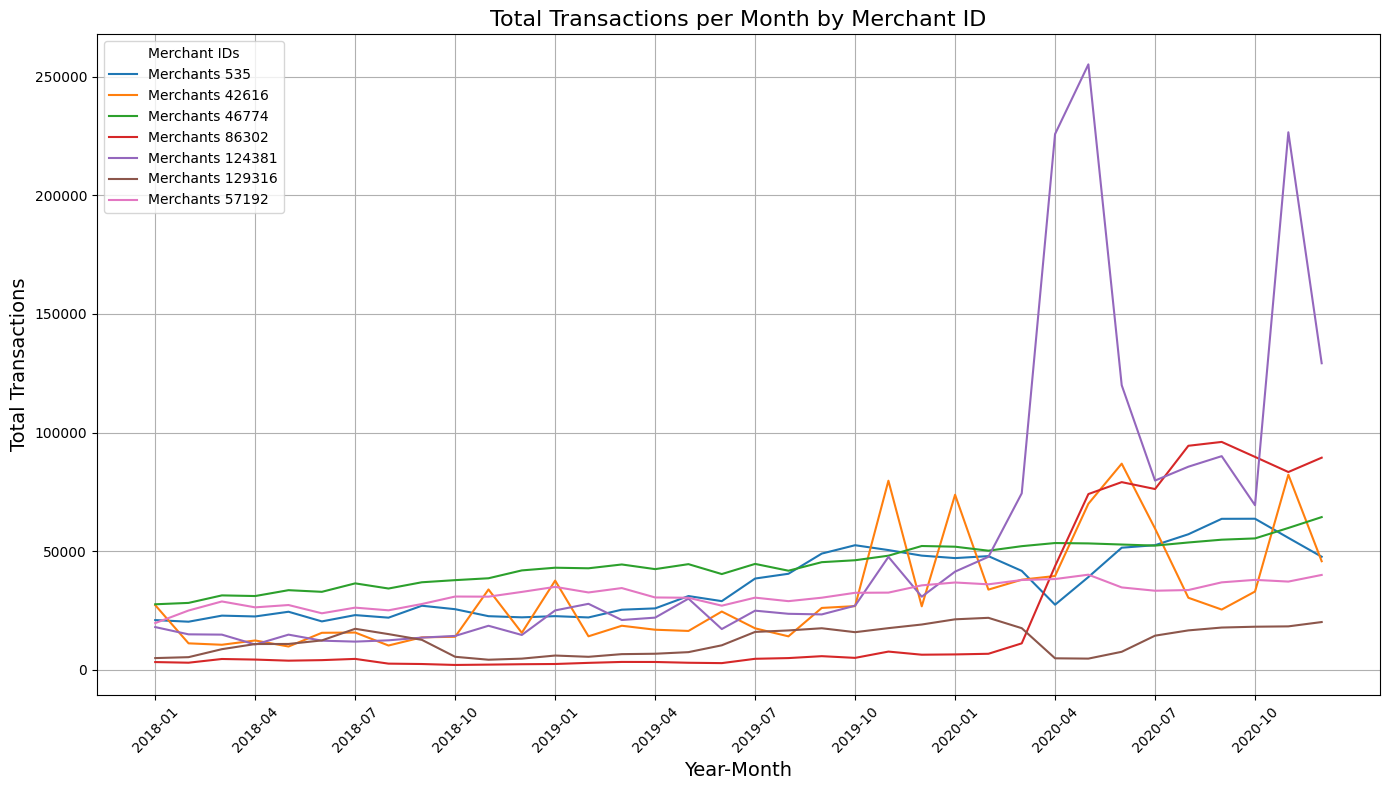

In [15]:
# Total Transactions per Month by Merchant ID Graphics
plt.figure(figsize=(14, 8))

for merchant_id in df['merchant_id'].unique():
    # Filtering Merchant ID
    df_filtered = df[df['merchant_id'] == merchant_id]

    grouped_data = df_filtered.groupby(['year', 'month'])['Total_Transaction'].sum()
    grouped_data.plot(label=f"Merchants {merchant_id}")
x_ticks = range(0, len(grouped_data), 3)  # 3 ayda bir etiket
x_labels = [f"{year}-{month:02d}" for year, month in grouped_data.index[x_ticks]]
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45, fontsize=10)
plt.title("Total Transactions per Month by Merchant ID", fontsize=16)
plt.xlabel("Year-Month", fontsize=14)
plt.ylabel("Total Transactions", fontsize=14)
plt.legend(title="Merchant IDs")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
#Random Noise
def random_noise(dataframe):
     return np.random.normal(scale=1.5, size=(len(dataframe),))

In [17]:
#Lag/Shifted Features
df.sort_values(by=['merchant_id','transaction_date'], axis=0, inplace=True)

df.groupby(["merchant_id"])['Total_Transaction'].transform(lambda x: x.shift(1))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['Transaction_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [90, 91, 92, 93, 178, 179, 180, 181, 182, 183, 184, 185,
                       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
                       544, 545, 546, 547, 548, 726, 727, 728,729,730])

In [18]:
#Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['Transaction_roll_mean_' + str(window)] = dataframe.groupby(["merchant_id"])['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [91, 92, 180, 185, 360, 365, 370, 540, 545, 730])

In [19]:
#Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['Transaction_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 92, 180, 185, 360, 365, 370, 540, 545, 730]

df = ewm_features(df, alphas, lags)

In [20]:
#Special Dates
df['is_black_friday'] = 0
df.loc[df['transaction_date'].isin(['2018-11-22','2018-11-23','2019-11-29','2019-11-30','2020-11-27','2020-11-28']), 'is_black_friday'] = 1

## Encoding

In [21]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['merchant_id', 'day_of_week', 'month'])

In [22]:
df.head()

,transaction_date,Total_Transaction,Total_Paid,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,is_15th_day,quarter,Transaction_lag_90,Transaction_lag_91,Transaction_lag_92,Transaction_lag_93,Transaction_lag_178,Transaction_lag_179,Transaction_lag_180,Transaction_lag_181,Transaction_lag_182,Transaction_lag_183,Transaction_lag_184,Transaction_lag_185,Transaction_lag_360,Transaction_lag_361,Transaction_lag_362,Transaction_lag_363,Transaction_lag_364,Transaction_lag_365,Transaction_lag_366,Transaction_lag_367,Transaction_lag_368,Transaction_lag_369,Transaction_lag_370,Transaction_lag_544,Transaction_lag_545,Transaction_lag_546,Transaction_lag_547,Transaction_lag_548,Transaction_lag_726,Transaction_lag_727,Transaction_lag_728,Transaction_lag_729,Transaction_lag_730,Transaction_roll_mean_91,Transaction_roll_mean_92,Transaction_roll_mean_180,Transaction_roll_mean_185,Transaction_roll_mean_360,Transaction_roll_mean_365,Transaction_roll_mean_370,Transaction_roll_mean_540,Transaction_roll_mean_545,Transaction_roll_mean_730,Transaction_ewm_alpha_095_lag_91,Transaction_ewm_alpha_095_lag_92,Transaction_ewm_alpha_095_lag_180,Transaction_ewm_alpha_095_lag_185,Transaction_ewm_alpha_095_lag_360,Transaction_ewm_alpha_095_lag_365,Transaction_ewm_alpha_095_lag_370,Transaction_ewm_alpha_095_lag_540,Transaction_ewm_alpha_095_lag_545,Transaction_ewm_alpha_095_lag_730,Transaction_ewm_alpha_09_lag_91,Transaction_ewm_alpha_09_lag_92,Transaction_ewm_alpha_09_lag_180,Transaction_ewm_alpha_09_lag_185,Transaction_ewm_alpha_09_lag_360,Transaction_ewm_alpha_09_lag_365,Transaction_ewm_alpha_09_lag_370,Transaction_ewm_alpha_09_lag_540,Transaction_ewm_alpha_09_lag_545,Transaction_ewm_alpha_09_lag_730,Transaction_ewm_alpha_08_lag_91,Transaction_ewm_alpha_08_lag_92,Transaction_ewm_alpha_08_lag_180,Transaction_ewm_alpha_08_lag_185,Transaction_ewm_alpha_08_lag_360,Transaction_ewm_alpha_08_lag_365,Transaction_ewm_alpha_08_lag_370,Transaction_ewm_alpha_08_lag_540,Transaction_ewm_alpha_08_lag_545,Transaction_ewm_alpha_08_lag_730,Transaction_ewm_alpha_07_lag_91,Transaction_ewm_alpha_07_lag_92,Transaction_ewm_alpha_07_lag_180,Transaction_ewm_alpha_07_lag_185,Transaction_ewm_alpha_07_lag_360,Transaction_ewm_alpha_07_lag_365,Transaction_ewm_alpha_07_lag_370,Transaction_ewm_alpha_07_lag_540,Transaction_ewm_alpha_07_lag_545,Transaction_ewm_alpha_07_lag_730,Transaction_ewm_alpha_05_lag_91,Transaction_ewm_alpha_05_lag_92,Transaction_ewm_alpha_05_lag_180,Transaction_ewm_alpha_05_lag_185,Transaction_ewm_alpha_05_lag_360,Transaction_ewm_alpha_05_lag_365,Transaction_ewm_alpha_05_lag_370,Transaction_ewm_alpha_05_lag_540,Transaction_ewm_alpha_05_lag_545,Transaction_ewm_alpha_05_lag_730,is_black_friday,merchant_id_535,merchant_id_42616,merchant_id_46774,merchant_id_57192,merchant_id_86302,merchant_id_124381,merchant_id_129316,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,349,25883.226,1,1,1,2018,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
6,2018-01-02,729,60263.928,2,2,1,2018,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [23]:
# Converting Total_Transactions to log(1+Total_Transactions)
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)

## Model

In [24]:
# Model
# Custom Cost Function
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [25]:
#SMAPE Object For LightGBM
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [26]:
# Time-Based Validation Sets
# Train set until the beginning of 2020 (end of 2019).
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]

# Validation set for the first 3 months of 2017.
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

cols = [col for col in train.columns if col not in ['transaction_date', 'Total_Transaction', "Total_Paid", "year"]]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 128), (644,), (644, 128))

In [27]:

# Time Series Model with LightGBM
# LightGBM parameters
# num_leaves: Total number of leaves in a tree, higher values increase model complexity.
# learning_rate: Determines how much the model learns in each iteration.
# feature_fraction: Percentage of features used in each iteration.
# max_depth: Maximum depth of each tree, can prevent overfitting.
# log_evaluation: verbose: Sets the level of detailed output during training.
# num_boost_round:n_estimators, Total number of iterations for training.
# early_stopping: Number of rounds to stop if no improvement in performance.
#nthread: Number of CPU threads to use during training.
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(params=lgb_params,
    train_set=lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    feval=lgbm_smape,
    callbacks=[lgb.early_stopping(lgb_params['early_stopping_rounds']),
        lgb.log_evaluation(10)])



Training until validation scores don't improve for 200 rounds
[10]	training's l2: 0.76932	training's SMAPE: 58.332	valid_1's l2: 0.96747	valid_1's SMAPE: 72.4069
[20]	training's l2: 0.589013	training's SMAPE: 51.6826	valid_1's l2: 0.730164	valid_1's SMAPE: 63.635
[30]	training's l2: 0.465388	training's SMAPE: 46.0766	valid_1's l2: 0.561022	valid_1's SMAPE: 55.5208
[40]	training's l2: 0.379768	training's SMAPE: 41.5472	valid_1's l2: 0.444474	valid_1's SMAPE: 48.6736
[50]	training's l2: 0.317765	training's SMAPE: 37.9997	valid_1's l2: 0.366305	valid_1's SMAPE: 43.3682
[60]	training's l2: 0.274035	training's SMAPE: 35.158	valid_1's l2: 0.303051	valid_1's SMAPE: 38.4912
[70]	training's l2: 0.242333	training's SMAPE: 32.8782	valid_1's l2: 0.259361	valid_1's SMAPE: 34.8584
[80]	training's l2: 0.219011	training's SMAPE: 31.0967	valid_1's l2: 0.227116	valid_1's SMAPE: 32.0727
[90]	training's l2: 0.200865	training's SMAPE: 29.6224	valid_1's l2: 0.202765	valid_1's SMAPE: 29.8359
[100]	training's

In [28]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
smape(np.expm1(y_pred_val), np.expm1(Y_val))

22.586452638328797

In [29]:
df_final =df.copy()
df_final.loc[df_final['transaction_date']>= '2020-10-01', 'Total_Transaction'] = np.expm1(y_pred_val)
df_final = df_final[df_final['transaction_date']>='2020-10-01']
df.loc[df['transaction_date']>= '2020-10-01', 'Total_Transaction'] = np.expm1(Y_val)
df.loc[df['transaction_date']< '2020-10-01', 'Total_Transaction'] = np.expm1(df['Total_Transaction'])

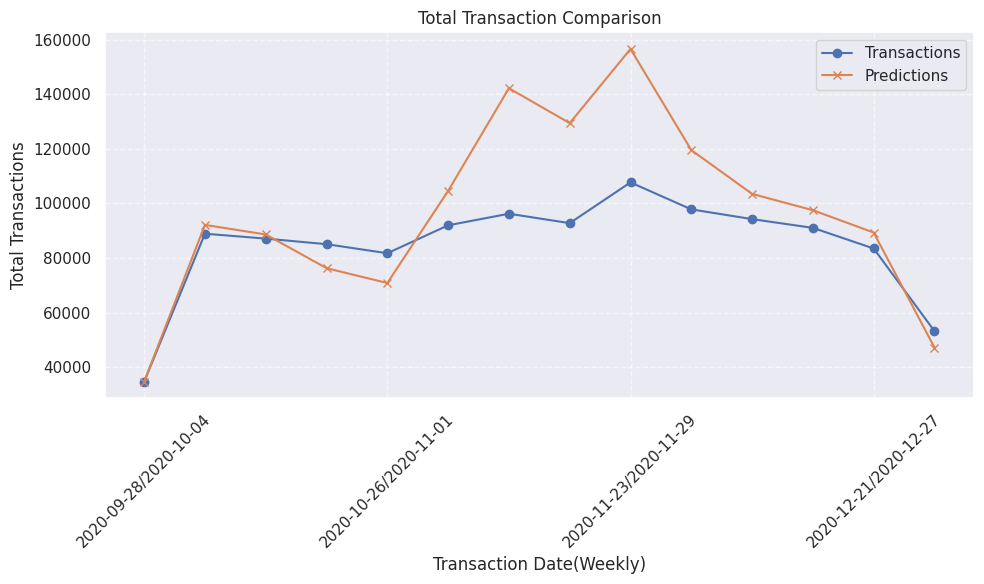

In [55]:
plt.figure(figsize=(10, 6))
df_final_filtered = df_final[df_final['transaction_date']>'2020-10-01']
df_filtered = df[df['transaction_date']>'2020-10-01']
weekly_final = df_final_filtered.groupby(df_final_filtered['transaction_date'].dt.to_period('W'))['Total_Transaction'].sum()
weekly_filtered = df_filtered.groupby(df_filtered['transaction_date'].dt.to_period('W'))['Total_Transaction'].sum()

plt.plot(weekly_final.index.astype(str), weekly_final.values, label='Transactions', marker='o')
plt.plot(weekly_filtered.index.astype(str), weekly_filtered.values, label='Predictions', marker='x')

plt.title('Total Transaction Comparison')
plt.xlabel('Transaction Date(Weekly)')
plt.ylabel('Total Transactions')
plt.xticks(ticks=range(0, len(weekly_final.index), 4), labels=weekly_final.index[::4].astype(str), rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Evaluation:**
* Transactions, especially in the 11th month, are significantly above our expectations.
* This is because November is a month with discount days like Black Friday.
* In addition, there was a shopping frenzy this month compared to previous years.
* Our estimates for other months seem to be in line with our expectations.

## Feature Importances

In [32]:

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp


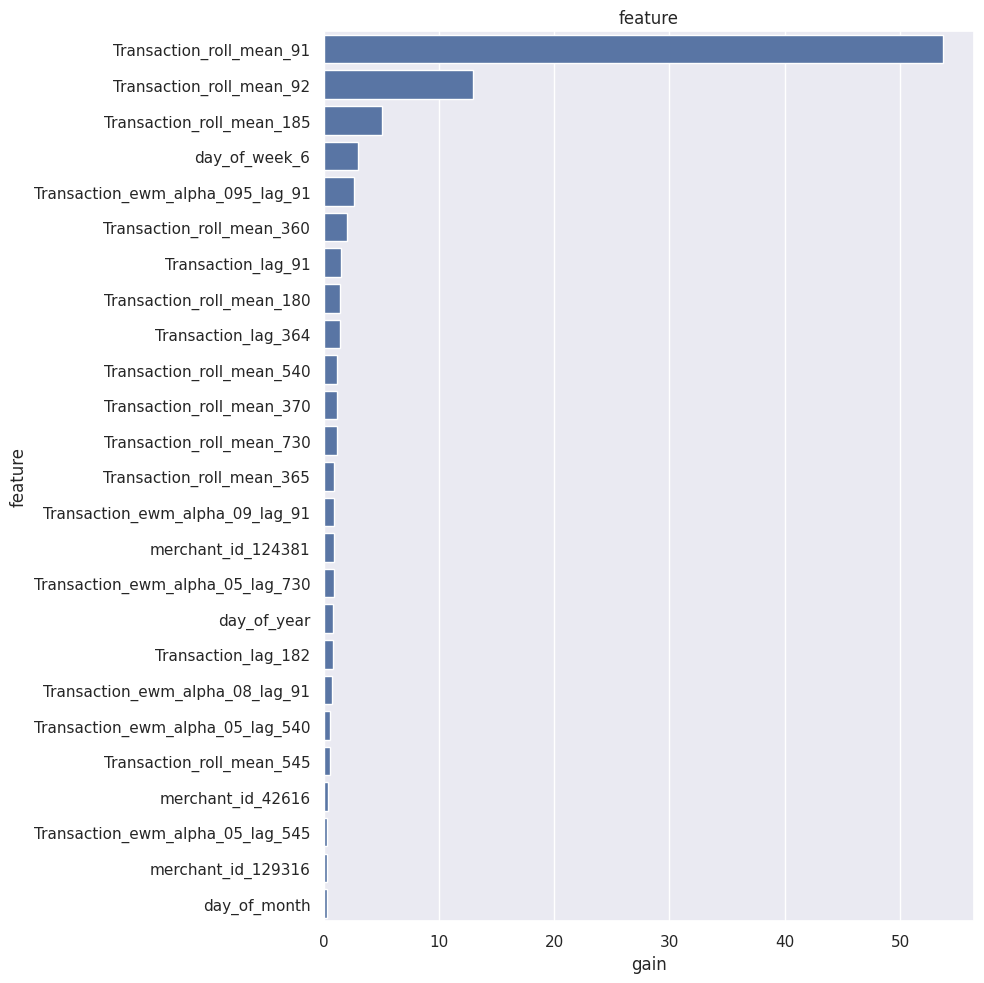

,feature,split,gain
41,Transaction_roll_mean_91,242,53.722997
42,Transaction_roll_mean_92,101,12.980398
44,Transaction_roll_mean_185,58,5.106010
115,day_of_week_6,146,2.983793
51,Transaction_ewm_alpha_095_lag_91,33,2.642837
...,...,...,...
65,Transaction_ewm_alpha_09_lag_360,0,0.000000
75,Transaction_ewm_alpha_08_lag_360,0,0.000000
82,Transaction_ewm_alpha_07_lag_92,0,0.000000
83,Transaction_ewm_alpha_07_lag_180,0,0.000000


In [33]:
plot_lgb_importances(model, num=30, plot=True)

### Unimportant Features

In [57]:
#Detection of only significant variables
feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
print(f"\nImportance Features: {len(imp_feats)}")
print(f"Unimportant Features: {len(importance_zero)}")

                              feature  split       gain
41           Transaction_roll_mean_91    242  53.722997
42           Transaction_roll_mean_92    101  12.980398
44          Transaction_roll_mean_185     58   5.106010
115                     day_of_week_6    146   2.983793
51   Transaction_ewm_alpha_095_lag_91     33   2.642837
..                                ...    ...        ...
65   Transaction_ewm_alpha_09_lag_360      0   0.000000
75   Transaction_ewm_alpha_08_lag_360      0   0.000000
82    Transaction_ewm_alpha_07_lag_92      0   0.000000
83   Transaction_ewm_alpha_07_lag_180      0   0.000000
127                          month_12      0   0.000000

[128 rows x 3 columns]

Importance Features: 102
Unimportant Features: 26
